In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import json
from torch.utils.data import TensorDataset, DataLoader, random_split

In [3]:
def get_data(filename):
    
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)

    df = pd.DataFrame(data)
    return df

In [4]:
data = get_data('output_file.json')

In [5]:
data.head()

,action_string,content_string,user_id,useraccount,user_class,src,tweet_count
0,rp|rp|⚀pr|□pr|rp|rr|rp|rp|pr|pr|pr|pr|pr|pp|rp...,(mmmmmmmmqt)(mmmmmmmmqt)|(mmmmmmmmqt)(mmmmmmmm...,146048090,146048090,bot,astroturf,274
1,r□p|r□r|r□r|p⚀r|⚀TT|TT|TT|T□r|⚀p⚀π|□p⚀r|r⚀r|r⚀...,(mmmmmmmqt)(mmmmmmmqt)|(mmmmmmmqt)(mmmmmmmqt)|...,797927149856403456,797927149856403456,bot,astroturf,274
2,r□r|⚀r⚀r|r□r|rr|□r□r|⚀rr|r⚀r|⚁rr|rr|r□r|rr|rr|...,(mmt)(mmt)|(qt)(qt)|(qt)(mqt)|(qt)(t)|(qt)(qt)...,1046169889138868225,1046169889138868225,bot,astroturf,276
3,pr|rp|p□r|rr|rr|rr|rr|rr|rr|r□r|r□r|rr|□rr|pr|...,(mmt)(mmmmmmqt)|(mmmmmmmmmqt)(mmt)|(mmt)(qt)|(...,1085010463128195073,1085010463128195073,bot,astroturf,244
4,p⚁p|⚀p□p|□p□p|⚁rr|rr|rr|rr|pr|□pr|rp|rr|□rr|rp...,(mmmmmmmqt)(Em)|(t)(mmqt)|(mt)(mmt)|(qt)(HUqt)...,1613166488,1613166488,bot,astroturf,244


In [6]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
from sklearn.utils import shuffle

# Assume `data` is your DataFrame
print("Original class distribution:")
print(data['user_class'].value_counts())

# Step 1: Separate data by user_class
bots = data[data['user_class'] == 'bot']
humans = data[data['user_class'] == 'human']

# Step 2: Balance the classes by downsampling the larger class
min_class_size = min(len(bots), len(humans))

# Downsample each class to the minimum class size
bots_balanced = bots.sample(n=min_class_size, random_state=1)
humans_balanced = humans.sample(n=min_class_size, random_state=1)

# Step 3: Combine the balanced classes
balanced_data = pd.concat([bots_balanced, humans_balanced])

# Step 4: Shuffle the data
balanced_data = shuffle(balanced_data, random_state=1).reset_index(drop=True)

print("Balanced class distribution:")
print(balanced_data['user_class'].value_counts())

data = balanced_data

Original class distribution:
user_class
human    42773
bot      32056
Name: count, dtype: int64
Balanced class distribution:
user_class
bot      32056
human    32056
Name: count, dtype: int64


In [8]:
print("data shape", data.shape)
print("columns", data.columns)

data shape (64112, 7)
columns Index(['action_string', 'content_string', 'user_id', 'useraccount',
       'user_class', 'src', 'tweet_count'],
      dtype='object')


In [9]:
import json
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.loc[idx, 'action_string']
        label = 1 if self.data.loc[idx, 'user_class'] == 'bot' else 0
        return {
            'text': text, 
            'label': label 
        }

dataset = CustomDataset(data)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example usage: Iterate through the test loader
# for batch in val_loader:
#     print(batch['text'], batch['label'])


In [10]:
# Counter: subclass of Python's dictionary used for counting hashable objects, in this case, tokens (words).
# OrderedDict: subclass of Python's dictionary that remembers the insertion order of keys. It is used to store tokens in a specific order based on frequency.
from collections import Counter, OrderedDict
# re: A module for working with regular expressions, used to manipulate and clean text.
import re

# Step 1: Token counts and vocab creation
# Initializes an empty Counter object to hold the frequency of each token in the dataset.
token_counts = Counter()

# Define tokenizer
def tokenizer(text):
    # text = re.sub('<[^>]*>', '', text)  # Remove HTML tags

    # This converts the entire text string to lowercase to ensure the regex matching is case-insensitive
    # Emoticons are case-insensitive, so text.lower is not necessary
    # emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())  # Extract emoticons

    # \W a shorthand in regex that matches any non-word character. Replace occurrences with space.
    # text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '') #adds emoticons to the cleaned text.

    #  creates a list of words (tokens)
    # tokenized = text.replace(" ", "").split("|")

    # return tokenized

    return list(text)

# Step 2: Tokenize the training data and populate token_counts
for entry in test_dataset:  # Assuming train_dataset is a dataset with 'text'
    line = entry['text']
    tokens = tokenizer(line)
    token_counts.update(tokens)

# Step 3: Sort tokens by frequency
# token_counts.items() returns the tokens and their respective counts as a list of tuples (e.g., [(token1, count1), (token2, count2), ...])
# key=lambda x: x[1] means that the sorting is based on the count (x[1]), which is the second element of each tuple
# reverse=True means that the most frequent tokens appear first in the sorted list.
sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Step 4: Limit the vocabulary to the top 69023 tokens (including special tokens)
# The padding token (pad) is used to ensure that all sequences in a batch have the same length.
# The unknown token (unk) is used to represent words that are not found in the model's vocabulary (the top 69021 words in your case).
# Any word that doesn't appear in the vocabulary is replaced by the unk token during tokenization.
# This is critical for handling unseen words during inference, where the model encounters words that were not present in the training data.
limited_sorted_by_freq_tuples = sorted_by_freq_tuples[:69021]  # Top 69021 + pad and unk

# Step 5: Create an ordered dictionary for the vocab
ordered_dict = OrderedDict(limited_sorted_by_freq_tuples)

# Step 6: Create vocab dictionary with special tokens
# Initializes the vocab dictionary with two special tokens
vocab = {"<pad>": 0, "<unk>": 1}

for idx, (token, count) in enumerate(ordered_dict.items(), start=2):  # Start from 2 to skip the special tokens
    vocab[token] = idx


# Print the vocabulary size (should be 69023)
print('Vocab-size:', len(vocab))
print('vocab', vocab)
# --- Rationale:
#
# By assigning frequent words lower indices, we can optimize memory and computational efficiency.
# Words that appear infrequently can either be assigned higher indices (in case we want to keep them) or omitted from the vocabulary entirely.

Vocab-size: 15
vocab {'<pad>': 0, '<unk>': 1, '|': 2, 'T': 3, 'r': 4, '⚁': 5, '⚀': 6, '□': 7, 'p': 8, '⚂': 9, '⚃': 10, 'π': 11, '⚄': 12, 'ρ': 13, '⚅': 14}


In [11]:
def encode(tokens):
    #If the token does not exist in the vocab, the function returns the index of the <unk>
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]
# Example usage
print(encode(list('rr|⚁rr|r⚁r|⚁rr|r□r|□r⚀T|⚀T⚀T|⚁rr|r□r|⚀rr|⚁T⚀T|⚀T⚀T|□rr|r□T|r⚀r|⚀r□r|⚀r⚀r|⚀p⚁r|□p⚀p|⚀T⚀r|□rr|⚁rr|□r□r|□rr|Tr|rr|r⚁r|⚀T⚁r|⚁T⚁r|r⚀r|r⚁r|⚀rr|r⚁r|⚀r⚁r|rr|⚁T⚀π|⚁T□r|r⚀T|⚀pr|⚁rr|r⚀T|⚀T□r|□p⚁r|□p⚀T|⚀rr|rr|□r⚁T|⚀T⚁r|rr|⚀T⚀r|⚀π⚁T|□r⚁r|⚁r□r|rr|⚀πp|⚁r⚁r|□r⚀T|⚀rr|r⚀r|rr|r⚁π|⚀r□p|□r⚁r|□r⚀p|□r⚀p|⚁p⚁r|rr|r□r|□r⚀r|r⚁r|⚀T⚀T|⚀r⚀r|⚁rr|rr|r⚀r|□r⚁r|rr|rr|⚀r⚁r|⚁r□r|⚁r□p|⚀r⚀r|□rr|r⚀π|⚀T⚀T|⚁rr|rr|rr|rr|rr|⚀T⚁r|⚀rp|rp|□r⚀r|□r⚀p|⚀r⚀r|⚀r□r|□r□r|rr|□r□r|⚀r⚁r|⚀rr|r□r|□rr|r□r|r□r|⚀r□r|⚀p⚀r|□r□r|⚀r⚀p|□rr|r⚀r|⚀r⚀r|□r□r|r⚁r|⚀r⚀r|⚀r□r|⚀r□r|⚀r⚁r|⚀r⚀r|⚀p⚀r|□r⚀r|⚀r□r|⚀T□T|□rr|□rr|r□r|□rr|r□T|pr|□rr|rr|⚀r⚀p|⚀r⚀r|⚀rr|□r□r|□rr|□rr|r□r|□r⚀r|⚀pr|□rr|rr|rr|rr|rr|rp|⚀r⚀r|r⚀r|□r⚀r')))  # Should output something like [11, 7, 35, 457]

[4, 4, 2, 5, 4, 4, 2, 4, 5, 4, 2, 5, 4, 4, 2, 4, 7, 4, 2, 7, 4, 6, 3, 2, 6, 3, 6, 3, 2, 5, 4, 4, 2, 4, 7, 4, 2, 6, 4, 4, 2, 5, 3, 6, 3, 2, 6, 3, 6, 3, 2, 7, 4, 4, 2, 4, 7, 3, 2, 4, 6, 4, 2, 6, 4, 7, 4, 2, 6, 4, 6, 4, 2, 6, 8, 5, 4, 2, 7, 8, 6, 8, 2, 6, 3, 6, 4, 2, 7, 4, 4, 2, 5, 4, 4, 2, 7, 4, 7, 4, 2, 7, 4, 4, 2, 3, 4, 2, 4, 4, 2, 4, 5, 4, 2, 6, 3, 5, 4, 2, 5, 3, 5, 4, 2, 4, 6, 4, 2, 4, 5, 4, 2, 6, 4, 4, 2, 4, 5, 4, 2, 6, 4, 5, 4, 2, 4, 4, 2, 5, 3, 6, 11, 2, 5, 3, 7, 4, 2, 4, 6, 3, 2, 6, 8, 4, 2, 5, 4, 4, 2, 4, 6, 3, 2, 6, 3, 7, 4, 2, 7, 8, 5, 4, 2, 7, 8, 6, 3, 2, 6, 4, 4, 2, 4, 4, 2, 7, 4, 5, 3, 2, 6, 3, 5, 4, 2, 4, 4, 2, 6, 3, 6, 4, 2, 6, 11, 5, 3, 2, 7, 4, 5, 4, 2, 5, 4, 7, 4, 2, 4, 4, 2, 6, 11, 8, 2, 5, 4, 5, 4, 2, 7, 4, 6, 3, 2, 6, 4, 4, 2, 4, 6, 4, 2, 4, 4, 2, 4, 5, 11, 2, 6, 4, 7, 8, 2, 7, 4, 5, 4, 2, 7, 4, 6, 8, 2, 7, 4, 6, 8, 2, 5, 8, 5, 4, 2, 4, 4, 2, 4, 7, 4, 2, 7, 4, 6, 4, 2, 4, 5, 4, 2, 6, 3, 6, 3, 2, 6, 4, 6, 4, 2, 5, 4, 4, 2, 4, 4, 2, 4, 6, 4, 2, 7, 4, 5, 4, 2, 4, 4, 2,

In [12]:
if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")

In [13]:
import torch
import torch.nn as nn
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the manual vocab creation process from earlier
# Assuming `vocab` and `tokenizer` are already defined

#text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
# Updated text pipeline
text_pipeline = lambda x: [vocab.get(token, vocab["<unk>"]) for token in tokenizer(x)]

label_pipeline = lambda x: float(x)  # Convert to float to match the output

# Batch collation function
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for entry in batch:  # Each 'entry' is a dictionary with 'text' and 'label'
        _label = entry['label']
        _text = entry['text']

        # Process labels and text
        label_list.append(label_pipeline(_label))  # Convert labels using label_pipeline
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)  # Convert text to indices

        # Store processed text and its length
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))

    # Convert lists to tensors and pad sequences
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True)

    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [14]:
#-----  Example usage with DataLoader -----#
## Take a small batch

dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))

# Print the output batch
print("Text batch:", text_batch)
print("Label batch:", label_batch)
print("Length batch:", length_batch)
print("Text batch shape:", text_batch.shape)

Text batch: tensor([[3, 5, 3,  ..., 3, 7, 3],
        [3, 9, 3,  ..., 0, 0, 0],
        [8, 9, 3,  ..., 0, 0, 0],
        [4, 6, 4,  ..., 0, 0, 0]], device='cuda:0')
Label batch: tensor([0., 0., 0., 0.], device='cuda:0')
Length batch: tensor([721, 718, 595, 367], device='cuda:0')
Text batch shape: torch.Size([4, 721])


In [15]:
## Batching the datasets

batch_size = 32

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
val_dl = DataLoader(val_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

In [16]:
# In the following, the embedding layer creates the number of features that will be fed into the RNN

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,
                                      embed_dim,
                                      padding_idx=0)
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size,
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
model = model.to(device)

In [17]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:  # Loop through batches in dataloader
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:  # Loop through batches in dataloader
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

Epoch 1 - accuracy: 0.7967, val_accuracy: 0.8364


Epoch 2 - accuracy: 0.8644, val_accuracy: 0.8845


Epoch 3 - accuracy: 0.8835, val_accuracy: 0.8890


Epoch 4 - accuracy: 0.8920, val_accuracy: 0.8891


Epoch 5 - accuracy: 0.8916, val_accuracy: 0.9004


Epoch 6 - accuracy: 0.9017, val_accuracy: 0.9042


Epoch 7 - accuracy: 0.9083, val_accuracy: 0.9082


Epoch 8 - accuracy: 0.9110, val_accuracy: 0.9065


Epoch 9 - accuracy: 0.9132, val_accuracy: 0.9120


Epoch 10 - accuracy: 0.9147, val_accuracy: 0.9116


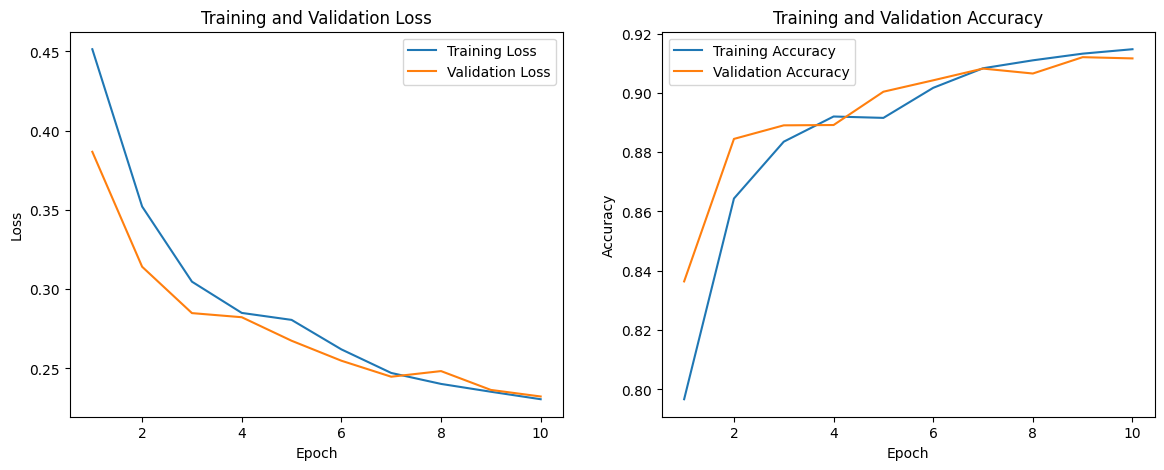

In [19]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Initialize lists to store training and validation metrics for each epoch
train_accuracies = []
train_losses = []
valid_accuracies = []
valid_losses = []

num_epochs = 10
torch.manual_seed(1)

# Training loop with metrics storage
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(val_dl)
    
    # Store metrics
    train_accuracies.append(acc_train)
    train_losses.append(loss_train)
    valid_accuracies.append(acc_valid)
    valid_losses.append(loss_valid)

    print(f'Epoch {epoch + 1} - accuracy: {acc_train:.4f}, val_accuracy: {acc_valid:.4f}')

# Plotting training and validation losses
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [20]:
acc_test, _ = evaluate(test_dl)
print(f'test_accuracy: {acc_test:.4f}')

test_accuracy: 0.9116


In [21]:
import pandas as pd
import torch
import random

# Function to preprocess and predict a single comment
def predict_comment(text, model, vocab):
    model.eval()
    # Tokenize and encode the input text using the same tokenizer and vocab as used during training
    tokens = tokenizer(text)
    encoded_text = [vocab.get(token, vocab["<unk>"]) for token in tokens]

    # Convert the tokens to tensor and add batch dimension
    text_tensor = torch.tensor(encoded_text).unsqueeze(0).to(device)  # Add batch dimension
    lengths_tensor = torch.tensor([len(encoded_text)]).to(device)

    with torch.no_grad():
        prediction = model(text_tensor, lengths_tensor)[:, 0]

    # Apply threshold of 0.5 for binary classification
    prediction_label = 1 if prediction >= 0.5 else 0
    return prediction.item(), prediction_label

# List to store prediction results
results = []

# Iterate over all samples in the test dataset
for sample in test_dataset:
    comment_text = sample['text']
    true_label = sample['label']
    predicted_value, predicted_label = predict_comment(comment_text, model, vocab)

    # Append the data for each comment
    results.append({
        "comment": comment_text,
        "true_label": true_label,
        "predicted_value": predicted_value,
        "predicted_label": predicted_label
    })

# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file
results_df.to_csv("predictions.csv", index=False)

print("Results saved to predictions.csv")

Results saved to predictions.csv


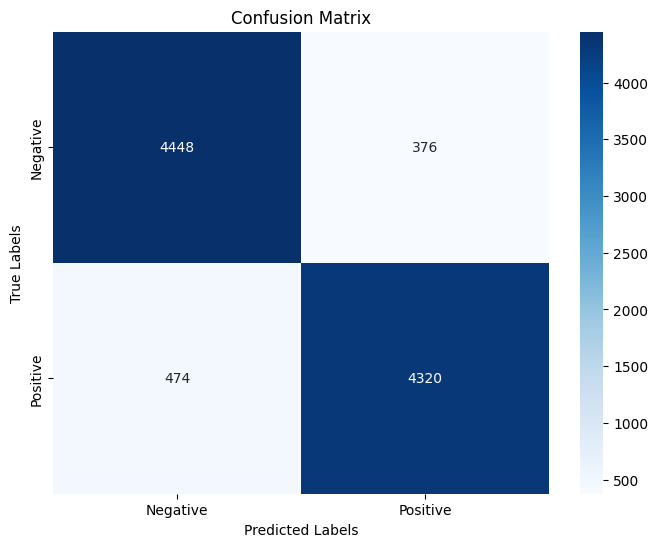

In [22]:
# Confusion matrix on the validation set
all_preds = []
all_labels = []

# Collect predictions and true labels from the validation set
for sample in test_dataset:
    comment_text = sample['text']
    true_label = sample['label']
    predicted_value, predicted_label = predict_comment(comment_text, model, vocab)  # Adjust if predict_comment takes a batch
    all_preds.append(predicted_label)
    all_labels.append(true_label)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
results_df[results_df['true_label'] != results_df['predicted_label']].to_csv("mismatches.csv")
results_df.shape

(9618, 4)